In [1]:
import itertools
import os
import re
import sys

import pandas as pd
import numpy as np
import scipy as sp

from sharknado.scipy.lib.data_manipulation import shark
from sharknado.scipy.transformers import signature
from sklearn.externals import joblib

%matplotlib inline
from IPython.core.pylabtools import figsize
from IPython.display import clear_output
from seaborn import plt

pd.options.display.max_columns = 999
pd.options.display.max_rows = 100

/usr/local/lib/python2.7/site-packages/boto/pyami/config.py:71: UserWarning: Unable to load AWS_CREDENTIAL_FILE (/usr/local/level/AwsCredFileShutUp)
  warnings.warn('Unable to load AWS_CREDENTIAL_FILE (%s)' % full_path)


# Goal

Train an LSTM sequence-to-sequence translator to convert messy merchant strings into readable merchant signatures. Eg:
```
TARGET T0834 TARGET T0 Elgin IL                  -> Target
Chk Card Purchase Taco Bell 4092                 -> Taco Bell
CHECKCARD 1031 DOMINO'S 4053 860-887-4567 CT 2   -> Domino's
CHECKCARD 0101 TAZIKIS MEDITERRA                 -> Tzarkis Mediterranean
GOLDFISH SWIMSCHOOL 614-407-3474                 -> Goldfish Swimschool
CHECKCARD 0110 LA BICYCLETTE CARMEL CA           -> La Bicyclette
```
## Data
We have regular expressions that allow us to extract about 200 known merchants from transactions. We will "subtract" these known merchants from the merchant strings that contain them to generate merchant string schemas.

We will then use the schemas to identify a much larger set of merchants.

Finally, we will randomly recombine schemas and merchats to create a synthetic set of merchant strings.

### Check out the known merchant extraction

In [96]:
by_seller = shark.Query("""
SELECT
  seller,
  COUNT(*) AS txns,
  COUNT(DISTINCT merchant) AS strings,
  COUNT(DISTINCT uid) AS users
FROM transactions
WHERE seller != "" AND aid REGEXP "^intuit"
GROUP BY seller
HAVING txns > (1.5 * users) AND users > 300
ORDER BY users DESC
""")

Querying sharknado at http://ec2-54-234-82-232.compute-1.amazonaws.com:4043


In [97]:
by_seller.head()

,seller,txns,strings,users
0,Walmart,6382770,2640241,222714
1,Amazon,8087534,2286796,221779
2,McDonald's,5099399,1986463,217960
3,Target,3862685,1358188,205148
4,Walgreens,2625897,1077816,196262


### Find some uncommon merchants
1. Find common schemas that surround our known merchants.
2. Pull other transactions with those schemas but without known merchants.
3. Separatre the schema from the new bits!

#### Find the merchant schemas with the actual merchant removed...

In [2]:
new_merchant_schemas = shark.Query(r"""
SELECT
  REGEXP_REPLACE(
      REGEXP_REPLACE(UPPER(merchant), UPPER(seller), "_____"),
      "\\d+", "0") AS schema,
  COUNT(*) AS txns,
  COUNT(DISTINCT uid) AS users,
  COUNT(DISTINCT merchant) AS strings,
  COUNT(DISTINCT seller) AS merchants
FROM transactions
WHERE seller != ""
  AND UPPER(merchant) REGEXP UPPER(seller)
GROUP BY
  REGEXP_REPLACE(
      REGEXP_REPLACE(UPPER(merchant), UPPER(seller), "_____"),
      "\\d+", "0")
HAVING merchants >= 10 AND users >= 50
ORDER BY merchants DESC, strings DESC, users DESC
""")

Querying sharknado at http://ec2-54-82-121-43.compute-1.amazonaws.com:4043


In [4]:
def ValidSchema(s):
    return (
        (s.strip() == s) and
        (not s.startswith("_")) and
        (not s.endswith("_")) and
        ("(" not in s) and
        (")" not in s) and
        ("#" not in s))

def MakeHiveRegexp(s):
    return "^" + s.replace("0", r"\\d+").replace("_____", "([A-Z '-]+)") + "$"

new_merchant_patterns = [MakeHiveRegexp(s) for s
 in new_merchant_schemas[new_merchant_schemas.merchants > 50].schema
 if ValidSchema(s)]

new_merchant_patterns

[u"^STORE PURCHASE ([A-Z '-]+) \\\\d+$",
 u"^PURCHASE ([A-Z '-]+) \\\\d+ ON \\\\d+/\\\\d+/\\\\d+$",
 u"^CHECK CARD: ([A-Z '-]+) \\\\d+$",
 u"^\\\\d+ ([A-Z '-]+) \\\\d+$",
 u"^POS PURCHASE ([A-Z '-]+) \\\\d+$",
 u"^WITHDRAWAL ([A-Z '-]+) \\\\d+$",
 u"^POS WITHDRAWAL ([A-Z '-]+) \\\\d+$",
 u"^DEBIT CARD: ([A-Z '-]+) \\\\d+$",
 u"^ATM ([A-Z '-]+) \\\\d+$",
 u"^WITHDRAWAL DEBIT ([A-Z '-]+) \\\\d+$",
 u"^STORE PURCHASE ([A-Z '-]+) \\\\d+ \\\\d+$",
 u"^POS WITHDRAWAL  ([A-Z '-]+) \\\\d+$",
 u"^DEBIT PURCHASE ([A-Z '-]+) \\\\d+$",
 u"^POS PURCHASE NON-PIN ([A-Z '-]+) \\\\d+$",
 u"^POS ([A-Z '-]+) \\\\d+$",
 u"^CARD TRANSACTION ([A-Z '-]+) \\\\d+$",
 u"^PURCHASE ([A-Z '-]+) \\\\d+$",
 u"^DEBIT CARD PURCHASE - ([A-Z '-]+) \\\\d+$",
 u"^POS PURCHASE NON PIN ([A-Z '-]+) \\\\d+$",
 u"^DEBIT PURCHASE -VISA ([A-Z '-]+) \\\\d+$",
 u"^POS WITHDRAWAL - ([A-Z '-]+) \\\\d+$",
 u"^POS WD ([A-Z '-]+) \\\\d+$",
 u"^\\\\d+ MCD PUR ([A-Z '-]+) \\\\d+$"]

#### And now some new merchants, surrounded by these schemas...

In [100]:
QUERY_OUTLINE = r"""
SELECT
  seller, COUNT(*) AS txns, COUNT(DISTINCT uid) AS users
FROM (
    SELECT
      uid,
      REGEXP_EXTRACT(UPPER(merchant), "{pat}", 1) AS seller
    FROM transactions
    WHERE seller = ""
      AND UPPER(merchant) REGEXP "{pat}"
      AND NOT scrubbed_merchant REGEXP "(TARGET)|(\\bPF\\b)"
    ) tmp
GROUP BY seller
HAVING users <= 5
"""

In [101]:
new_merch_dfs = []
processed_patterns = set([])

In [102]:
for p in new_merchant_patterns:
    if p not in processed_patterns:
        new_merch_dfs.append(shark.Query(QUERY_OUTLINE.format(pat=p)))
        processed_patterns.add(p)

Querying sharknado at http://ec2-54-234-82-232.compute-1.amazonaws.com:4043
Querying sharknado at http://ec2-54-234-82-232.compute-1.amazonaws.com:4043
Querying sharknado at http://ec2-54-234-82-232.compute-1.amazonaws.com:4043
Querying sharknado at http://ec2-54-234-82-232.compute-1.amazonaws.com:4043
Querying sharknado at http://ec2-54-234-82-232.compute-1.amazonaws.com:4043
Querying sharknado at http://ec2-54-234-82-232.compute-1.amazonaws.com:4043
Querying sharknado at http://ec2-54-234-82-232.compute-1.amazonaws.com:4043
Querying sharknado at http://ec2-54-234-82-232.compute-1.amazonaws.com:4043
Querying sharknado at http://ec2-54-234-82-232.compute-1.amazonaws.com:4043
Querying sharknado at http://ec2-54-234-82-232.compute-1.amazonaws.com:4043
Querying sharknado at http://ec2-54-234-82-232.compute-1.amazonaws.com:4043
Querying sharknado at http://ec2-54-234-82-232.compute-1.amazonaws.com:4043
Querying sharknado at http://ec2-54-234-82-232.compute-1.amazonaws.com:4043
Querying sha

In [103]:
rare_sellers_df = pd.concat(new_merch_dfs, ignore_index=True)

#### Clean up the start & end of our merchant strings...

In [104]:
DROP = set([
    "PURCHASE", "WITHDRAWAL", "DEBIT", "PUR", "CARD", "TRANSACTION", "SIGNATURE", "RECURRING",
    "POINT", "OF", "SALE", "ADVANCE", "PURCH", "WITH", "TRNSCTN",
    "POS", "WD", "NNT", "PAYMENT", "DDA", "MCD", "SIG", "FROM", "RETURN", "-",
    "PRE-AUTH", "NON-PIN", "NON", "DEPOSIT", "VISA", "PIN", "PINNED",
    "RTN", "OMO", "VSA", "CHK", "MAC", "NWS", "CNS"])

def FixMerchant(s):
    s = s.strip("-")
    try:
        parts = s.split()
        while parts[0] in DROP:
            parts = parts[1:]
        return signature.Signature(" ".join(parts), drop_nonalpha=False)
    except:
        return s

In [105]:
rare_sellers_df["fixed_seller"] = rare_sellers_df.seller.map(FixMerchant)

In [106]:
rare_sellers = rare_sellers_df.fixed_seller.unique()

In [107]:
list(rare_sellers)[:20]

[u'HASTINGS ENTRMT',
 u'DSW SHOE WAREHOUSE',
 u'BRILLOBOX',
 u"TONY'S SEAFOOD",
 u'SEES CANDY SHOP',
 u'FRYS FUEL',
 u'ENTERPRISE RENTACAR FORT WORTH',
 u'CORFU GREEK RESTAURANT',
 u'SIX FLAGS MAGIC MOUNTAIN',
 u'IRVINE RANCH MARKET',
 u'BLAZE PIZZA FRESNO',
 u'US NAILS',
 u'PERLYS',
 u'ROMAN DELIGHT PIZZ',
 u'SVC OIL COLBY BULK PLANT',
 u'COACH INC',
 u'OWASA MARATHON',
 u'TOPS MARKET',
 u'IKEA HOME SHOPPING',
 u'ASTRO']

#### And save it to the references folder.

In [109]:
OUTPATH = os.path.join(os.path.dirname(os.getcwd()), "references", "rare_merchants.txt")
with open(OUTPATH, "w") as f:
    f.write("\n".join(rare_sellers))

### Now find as great a variety of merchant schemas as we possibly can.
The schemas we pulled before needed primarily to be parsable, so that we could extract new merchant strings with high fidelity. These need to be diverse: we want the full wacky range of garbage that flows through the sewage pipes of Plaid, Intuit, and their knavish kin.

In [ ]:
# We did this in make_dataset.py!

### And recombine the schemas with the rare merchants to make our synthetic training set.

In [ ]:
# We did this in build_features.py!

# Atreous Convolutional Models

In [192]:
from keras import backend as K
from keras import models, layers
from keras.engine.topology import Layer
from neural_merchant_scrubbing.src.features import build_features as bf

In [240]:
model_dir = os.path.join(os.path.dirname(os.getcwd()), "models")
m = models.load_model(os.path.join(
    model_dir,
    "em24_ch32_ba32_ep20_bpe100_sw125_pm_ps_mr0.05_20161207225431.model"))

In [241]:
def Scrub(m, s):
    v = bf.CharacterVectorizer()
    encoded = v.transform([s.upper()]).toarray()
    starts, stops = m.predict(encoded)
    return s[starts.argmax():stops.argmax()]

def ScrubBatch(m, s):
    v = bf.CharacterVectorizer()
    encoded = v.transform([ss.upper() for ss in s]).toarray()
    starts, stops = m.predict(encoded)
    return [
        ss[start:stop].upper()
        for ss, start, stop
        in zip(s, starts.argmax(1), stops.argmax(1))]

In [242]:
def GetPredictions(m, s):
    v = bf.CharacterVectorizer()
    encoded = v.transform([s.upper()]).toarray()
    starts, stops = m.predict(encoded)
    return starts, stops

def Visualize(m, s):
    starts, stops = GetPredictions(m, s)
    slen = max(len(s), 50)
    x = np.arange(slen)
    figsize(12, 1.5)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.bar(x, starts[0][:slen], color="green", alpha=0.5)
    ax.bar(x, stops[0][:slen], color="red", alpha=0.5)
    plt.xticks(x + 0.3, s.upper())
    plt.xlim(0, slen)
    plt.title("Model Predoctions of Merchant Start and End")
    ax.set_yticklabels([])
    plt.show()

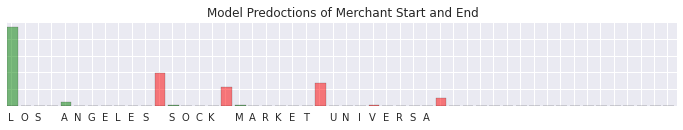

In [243]:
Visualize(m, "LOS ANGELES SOCK MARKET UNIVERSA")

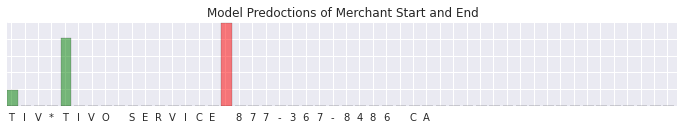

In [244]:
Visualize(m, "TIV*TIVO SERVICE 877-367-8486 CA")

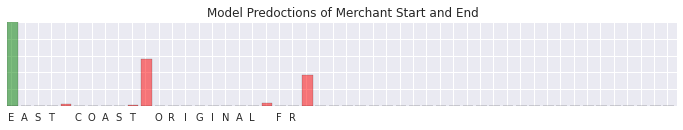

In [245]:
Visualize(m, "East Coast Original Fr")

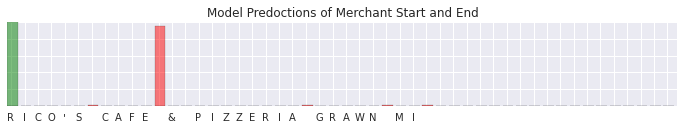

In [246]:
Visualize(m, "RICO'S CAFE & PIZZERIA GRAWN MI")

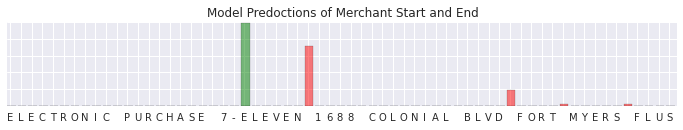

In [247]:
Visualize(m, "Electronic Purchase 7-ELEVEN 1688 COLONIAL BLVD FORT MYERS FLUS")

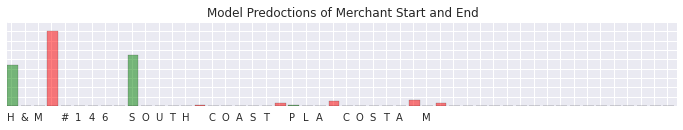

In [248]:
Visualize(m, "H&M #146 SOUTH COAST PLA COSTA M")

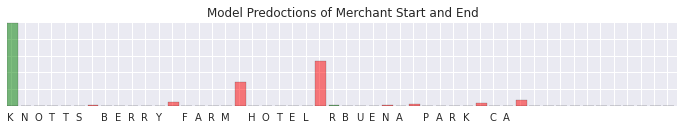

In [249]:
Visualize(m, "KNOTTS BERRY FARM HOTEL RBUENA PARK CA")

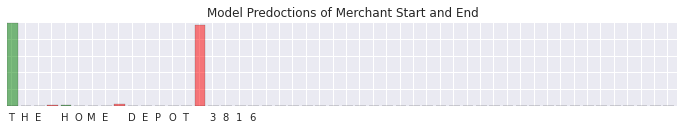

In [250]:
Visualize(m, "The HOME DEPOT 3816")

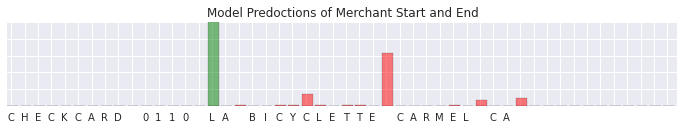

In [251]:
Visualize(m, "CHECKCARD t have  LA BICYCLETTE CARMEL CA")

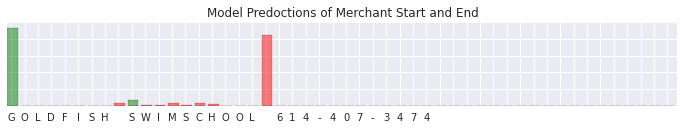

In [252]:
Visualize(m, "GOLDFISH SWIMSCHOOL 614-407-3474")

In [253]:
ugly = shark.Query("""
SELECT merchant
FROM transactions
ORDER BY clear_date DESC
LIMIT 20000
""")

Querying sharknado at http://ec2-107-20-123-161.compute-1.amazonaws.com:4043


In [254]:
ugly["scrub"] = ScrubBatch(m, ugly.merchant)

In [255]:
cv = bf.CharacterVectorizer()
u_starts, u_stops = m.predict(cv.transform(ugly.merchant).toarray())

In [256]:
ugly["entropy"] = (
    sp.special.entr(u_starts).sum(axis=1) + sp.special.entr(u_stops).sum(axis=1) / np.log(2))

In [257]:
ugly["confidence"] = u_starts.max(axis=1) * u_stops.max(axis=1)

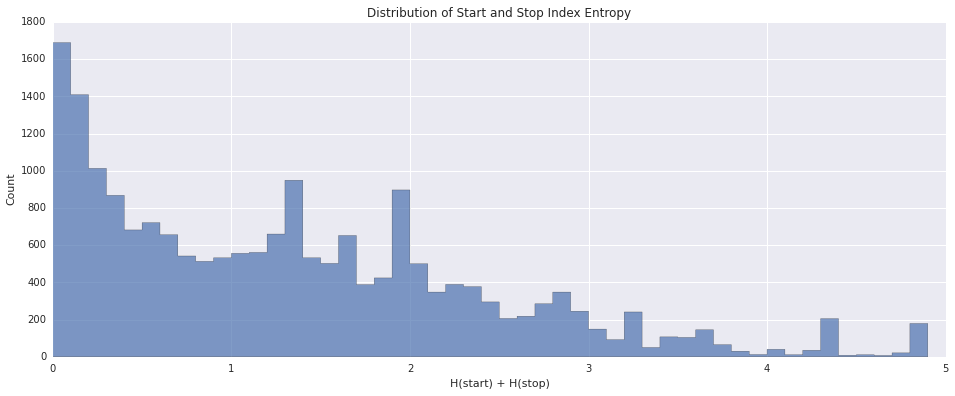

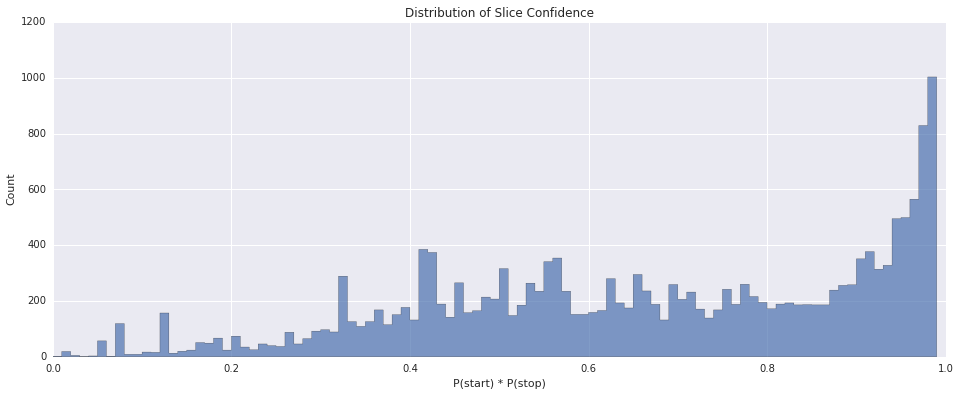

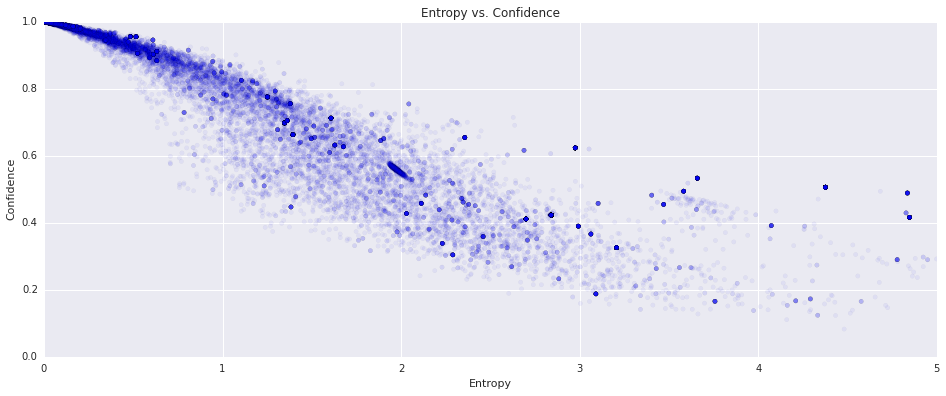

In [258]:
figsize(16, 6)
plt.hist(ugly.entropy, bins=np.arange(0, 5, 0.1), histtype="stepfilled", alpha=0.7)
plt.title("Distribution of Start and Stop Index Entropy")
plt.ylabel("Count")
plt.xlabel("H(start) + H(stop)")
plt.show()

plt.hist(ugly.confidence, bins=np.arange(0, 1, 0.01), histtype="stepfilled", alpha=0.7)
plt.title("Distribution of Slice Confidence")
plt.ylabel("Count")
plt.xlabel("P(start) * P(stop)")
plt.show()

plt.title("Entropy vs. Confidence")
plt.scatter(ugly.entropy, ugly.confidence, alpha=0.05)
plt.xlim(0, 5)
plt.ylim(0, 1)
plt.xlabel("Entropy")
plt.ylabel("Confidence")
plt.show()

In [265]:
ugly.iloc[10000:10100]

,merchant,scrub,entropy,confidence
10000,DEBIT CARD WITHDRAWAL PURCHASE ROCKET LAWYER I...,ROCKET LAWYER INC,1.051225,0.810689
10001,RAINIER ESPRESSO & PIZZ RAINIER,RAINIER ESPRESSO & PIZZ RAINIER,1.804381,0.505768
10002,POS Withdrawal APL* ITUNES.COM/,ITUNES,0.641355,0.909871
10003,"Accenture, LLP","ACCENTURE, LLP",0.233523,0.969566
10004,Point Of Sale Withdrawal TRACTO,POINT OF SALE WITHDRAWAL TRACTO,2.894682,0.458282
10005,AMAZON MKTPLACE PMTS,AMAZON MKTPLACE PMTS,0.205203,0.979876
10006,CHASE AUTOPAY 161205,CHASE,1.010695,0.760269
10007,AMAZON MKTPLACE PMTS,AMAZON MKTPLACE PMTS,0.205203,0.979876
10008,VISA - 12/03 GOOD EARTH NATURAL FOO OGDEN UT 0...,GOOD EARTH NATURAL,1.965866,0.449144
10009,POS Withdrawal - M & J MART 6352,M & J MART,0.193551,0.960772


In [8]:
new_merchant_schemas[:-1000]

,schema,txns,users,strings,merchants
0,_____,25375857,201860,620,199
1,_____ 0,1538153,101752,116935,178
2,_____ #0,1522556,77668,76451,139
3,_____,1709,580,179,134
4,0 _____,53208,19846,4119,123
5,WITHDRAWAL DEBIT _____,22591,275,108,106
6,_____ 0,72402,7271,11691,103
7,STORE PURCHASE _____ 0,8912,901,3777,101
8,_____ 0 0,238756,41167,17078,100
9,PURCHASE _____ 0 ON 0/0/0,10852,585,10191,85
